# **Model Selection for Prediction of MPG of Cars and Possible Explanatory Variables**

#### Authors: Felix Li, Naaimur Reza, Nitahi Escolar Bach & Yingshan Wu

## Introduction

Canada's climate poses special challenges for fuel-efficient driving. Besides factors such as weather, road conditions
and traffic conditions other more universal factors such as a car's weight, horsepower, and number of cylinders in it
can also affect fuel efficiency. Furthermore, Canada's GHG emission standards are becoming more strict and with fuel
prices on the rise it's important to learn how and which factors affect the mileage of one's vehicle and be able to
predict the MPG(**Miles Per Gallon**) given external factors. **Our project aims to present all possible linear regression models(in the scope of this class) for predicting MPG and answer which
model is the best.**

For our predictive analysis we have decided to use "Auto MPG Data Set" taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset was used in the 1983 American Statistical Association Exposition. Attributes include city-cycle fuel consumption in miles per gallon, number of cylinders, displacement, horsepower, weight, acceleration, car model year, origin and car name.

Two academic studies that we deemed relevant for this study are: Neelesh A. Patankar, Jane Lin & Tanvee N. Patankar(2021) claimed fuel economy (measured in miles per gasoline gallon equivalent or mpgge) is an absolute measure and tells little about the real mileage efficiency of a car, because efficiency is a relative measure depending on both the input and output and, does not take into account external factors such as road infrastructure and driving conditions. Zoe L., Christine K., Reuven S. & Jonn A. (2021) found that presentation of fuel economy information may increase selection of efficient vehicles.

## Method and Result

In [46]:
# First, we will load required packages
options(repr.plot.width=8, repr.plot.height=6)
library(tidyverse)
library(tidymodels)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(broom)
install.packages("latex2exp")
library(latex2exp)
library(digest)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)


# Then, set the seed
set.seed(1111)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



#### I. Load data from the web

In [47]:
# URL
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

# Download the dataset from the web
dir.create("data")
destFile <- "data/localfile.data"
download.file(url, destFile)

Warning message in dir.create("data"):
“'data' already exists”


#### II. Clean and wrangle the data into a tidy format

In [48]:
# Convert from .data file to a dataframe
raw_mpg_data <- read.delim("data/localfile.data", sep= "", header = FALSE)

head(raw_mpg_data)

,V1,V2,V3,V4,V5,V6,V7,V8,V9
,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>
1,18,8,307,130.0,3504,12.0,70,1,chevrolet chevelle malibu
2,15,8,350,165.0,3693,11.5,70,1,buick skylark 320
3,18,8,318,150.0,3436,11.0,70,1,plymouth satellite
4,16,8,304,150.0,3433,12.0,70,1,amc rebel sst
5,17,8,302,140.0,3449,10.5,70,1,ford torino
6,15,8,429,198.0,4341,10.0,70,1,ford galaxie 500


**Explanation**: The raw data is auto-mpg-1.data with 9 columns V1-V9 including data type real number, integer and categorical.

In [72]:

mpg_data_tidy <- raw_mpg_data %>%
        mutate(mpg = V1, cylinders = V2, displacement =V3, horsepower = V4, 
                    weight = V5, acceleration = V6, model_year = V7, origin = V8) %>%
        select(mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin)

mpg_data_tidy$cylinders <- as.factor(mpg_data_tidy$cylinders)

mpg_data_tidy$horsepower <- as.integer(mpg_data_tidy$horsepower)

mpg_data <- mpg_data_tidy %>% 
        select(mpg,cylinders,displacement,horsepower,weight,acceleration) %>%
        filter(!is.na(mpg_data_tidy$horsepower)) 


head(mpg_data)
levels(mpg_data$cylinders)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


,mpg,cylinders,displacement,horsepower,weight,acceleration
,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>
1,18,8,307,130,3504,12.0
2,15,8,350,165,3693,11.5
3,18,8,318,150,3436,11.0
4,16,8,304,150,3433,12.0
5,17,8,302,140,3449,10.5
6,15,8,429,198,4341,10.0


[1] "3" "4" "5" "6" "8"

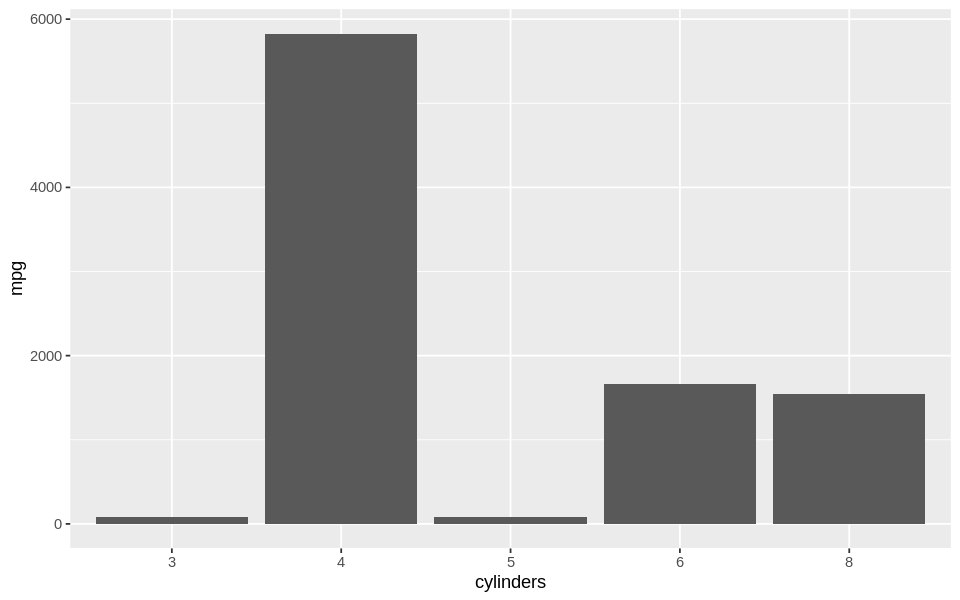

In [78]:
options(repr.plot.width = 8, repr.plot.height = 5)

p<-ggplot(data=mpg_data, aes(x=cylinders, y=mpg)) +
  geom_bar(stat="identity")
p

In [63]:
mpg_data <- mpg_data %>%
  mutate(cylinders= ifelse(cylinders == '3',"low",
                             ifelse(cylinders == '4', "low",
                                    ifelse(cylinders == '5', "high",
                                           ifelse(cylinders == '6', "high", 
                                                  ifelse(cylinders == '8', "high",NA)))))) 


head(mpg_data)

,mpg,cylinders,displacement,horsepower,weight,acceleration
,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
1,18,high,307,130,3504,12.0
2,15,high,350,165,3693,11.5
3,18,high,318,150,3436,11.0
4,16,high,304,150,3433,12.0
5,17,high,302,140,3449,10.5
6,15,high,429,198,4341,10.0


**Explanation**: we rename all the columns to proper names and turn the type of cylinders into factor since it is a categorical 
variable with only 5 types. And we delete rows with a missing data. Also turn the type of horsepower into integer, and then we 
get rid of column V7,V8,V9 which represents car name, model_year,and origin. car name includes over 100 different strings, and
it makes no sense to turn it into a categorical variable,so we decide to take away this column, for model_year, it is a discrete 
variable which is also over 10 different levels,so we decide to get rid of it. For origin the data does not provide information 
with what 1,2,3 represent so, we won't use this column.

#### III. Plots

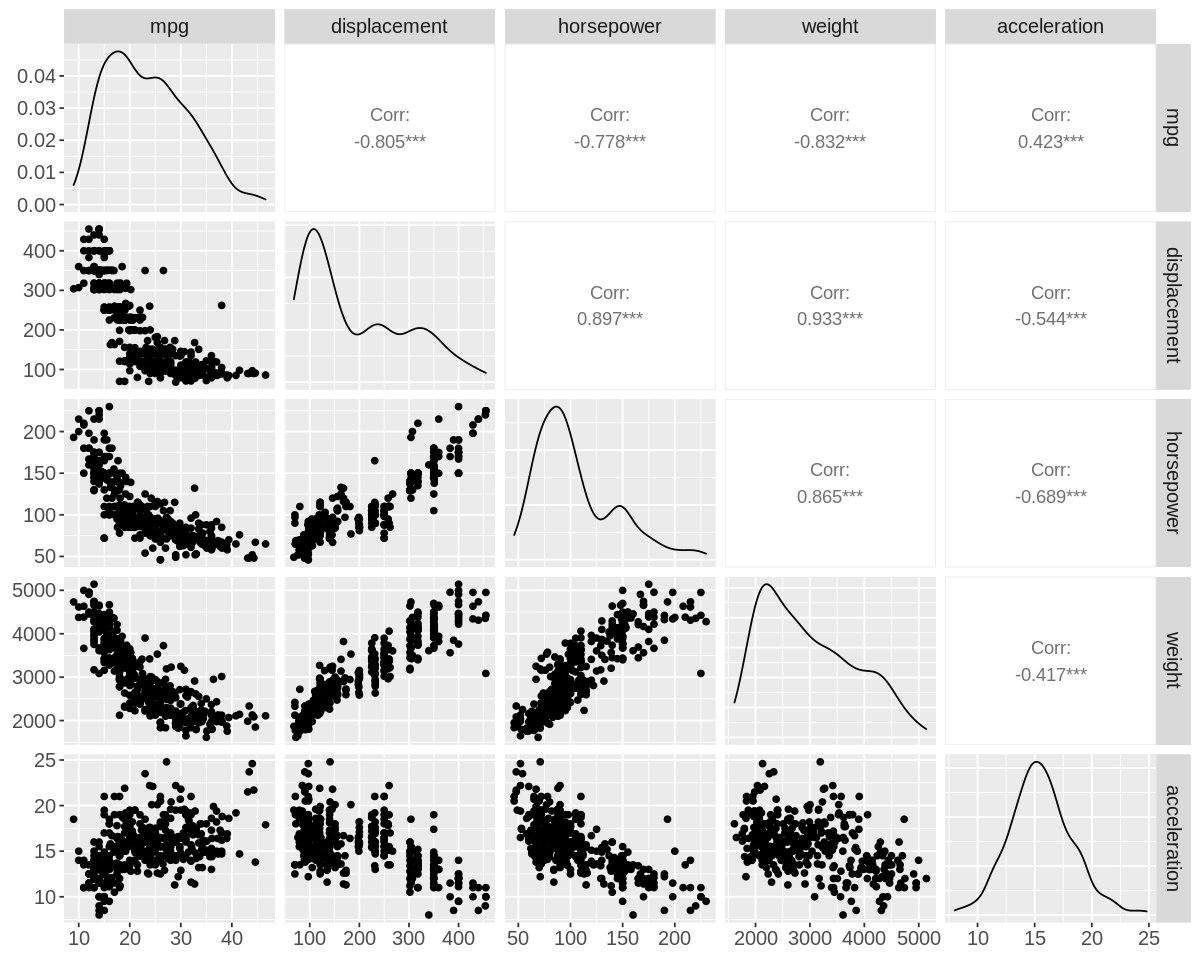

In [64]:
options(repr.plot.width = 10, repr.plot.height = 8)

correlation_plots <- mpg_data %>%
  select(- cylinders) %>%
  ggpairs(progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )
  
correlation_plots

**Explanation**: The correlation plots show the scatterplot of each pair of variables, so that the shape and correlation between variables are clear to see.  Weight and displacement seems to have a very high positive correlation which is 0.933, weight and mpg has a very high negative correlation which is -0.832. The 

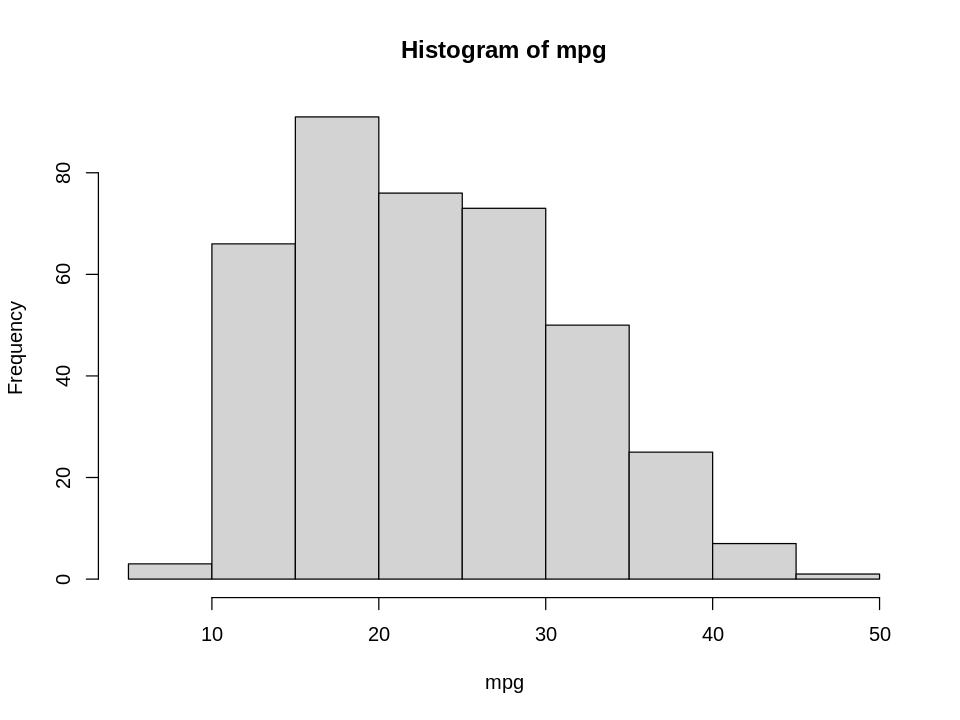

In [65]:
options(repr.plot.width = 8, repr.plot.height = 6)
hist(mpg_data$mpg,
    main="Histogram of mpg",
    xlab="mpg")

**Explanation**: This histogram shows the distribution of our response varibale "mpg", which is "roughly" a normal distibution

In [66]:
summary(mpg_data$mpg)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9.00   17.00   22.75   23.45   29.00   46.60 

### Forward selection

In [67]:
mpg_forward_sel <- regsubsets(
  x = mpg ~ ., nvmax = 5,
  data = mpg_data,
  method = "forward",
)
    
mpg_forward_summary <- summary(mpg_forward_sel)
mpg_forward_summary

Subset selection object
Call: regsubsets.formula(x = mpg ~ ., nvmax = 5, data = mpg_data, method = "forward", 
    )
5 Variables  (and intercept)
             Forced in Forced out
cylinderslow     FALSE      FALSE
displacement     FALSE      FALSE
horsepower       FALSE      FALSE
weight           FALSE      FALSE
acceleration     FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: forward
         cylinderslow displacement horsepower weight acceleration
1  ( 1 ) " "          " "          " "        "*"    " "         
2  ( 1 ) "*"          " "          " "        "*"    " "         
3  ( 1 ) "*"          " "          "*"        "*"    " "         
4  ( 1 ) "*"          "*"          "*"        "*"    " "         
5  ( 1 ) "*"          "*"          "*"        "*"    "*"         

In [68]:
mpg_forward_summary_df <- tibble(
    n_input_variables = 1:5,
    RSQ = mpg_forward_summary$rsq,
    RSS = mpg_forward_summary$rss,
    ADJ.R2 = mpg_forward_summary$adjr2,
    Cp = mpg_forward_summary$cp,
    BIC = mpg_forward_summary$bic,
)
mpg_forward_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6926304,7321.234,0.6918423,44.293945,-450.5016
2,0.7081556,6951.440,0.7066551,24.458908,-464.8477
3,0.7233301,6589.998,0.7211909,5.116946,-479.8076
4,0.7254629,6539.199,0.7226253,4.117426,-476.8698
5,0.7255463,6537.210,0.7219912,6.000000,-471.0178


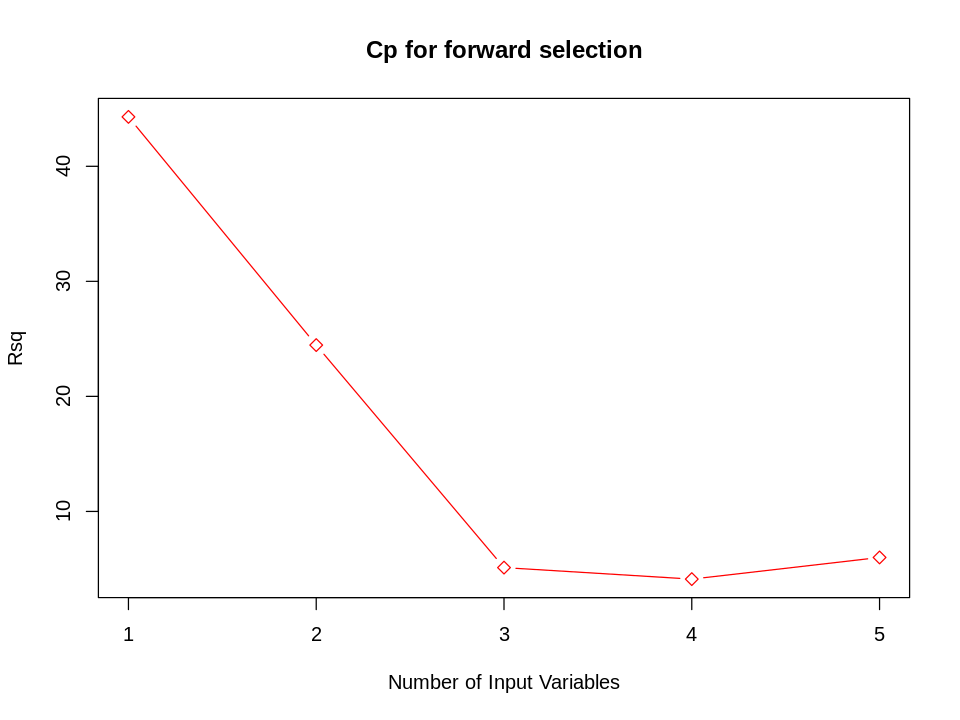

In [69]:
plot(summary(mpg_forward_sel)$cp,
  main = "Cp for forward selection",
  xlab = "Number of Input Variables", ylab = "Rsq", type = "b", pch = 5,
  col = "red"
)

### lasso regression

In [70]:
set.seed(1234)

mpg_data$ID <- 1:nrow(mpg_data)
training_mpg <- sample_n(mpg_data, size = nrow(mpg_data) * 0.60,
  replace = FALSE
)

testing_mpg <- anti_join(mpg_data,
  training_mpg,
  by = "ID"
)



training_mpg <- training_mpg %>% select(-"ID")
testing_mpg <- testing_mpg %>% select(-"ID")

mpg_X_train <- training_mpg %>% select(-"mpg")  %>% data.matrix()
mpg_Y_train <- training_mpg %>% select("mpg")  %>% data.matrix()


mpg_X_test <- testing_mpg %>% select(-"mpg")  %>% data.matrix()
mpg_Y_test <- testing_mpg %>% select("mpg")  %>% data.matrix()


In [71]:
mpg_cv_lambda_LASSO <- cv.glmnet(
  x = mpg_X_train, y = mpg_Y_train,
  alpha = 1,
  lambda = exp(seq(1, 12, 0.1))
)

## Method

The report is trustworthy because it is based on data from a reliable source. The data used it the Auto MPG Data Set which is maintained by a reliable source, Carnegie Mellon University. It will also give insight into fuel efficient cars which are important because of the large amount of emissions cars create.

This report, as mentioned above, will present all possible linear regression models(in the scope of this class) for predicting MPG and answer which model is the best.

Currently we only have simple statistics on the correlation between the variables. This doesn't give much insight into this question, except that there is a lot of positive and negative correlation between the variables.

Since we have all these correlated variables, we will check the VIF of the input variables and remove variables to get a VIF under 10(we will decide which ones are most appropriate to remove based on existing knowledge on MPG). We choose under 10 because when it is over 10 it is evidence of severe multicollinearity.

From here we will create every combination of model with and without interaction. We will compare these models by running them through 5-fold cross validation and picking the one that achieves the best Mean Squared Error. We are doing cross validation to approximate test Mean Squared Error

We expect to create a model which will be able to accurately predict the MPG of a vehicle given the input variables the model uses.

We believe this model could be impactful because it could help consumers choose fuel efficient vehicles. When choosing a vehicle you can put the necessary data into the model and it will give you an estimated MPG. 

## References

Neelesh A. Patankar, Jane Lin & Tanvee N. Patankar(October, 2021), <em>Mileage efficiency of cars</em>, vol. 4, ScienceDirect. Retrieved November 3, 2022 from https://www.sciencedirect.com/science/article/pii/S2666790821002007#

Zoe Long, Christine Kormos, Reuven Sussman & Jonn Axsena (April, 2021), <em>MPG, fuel costs, or savings? 
Exploring the role of information framing in consumer valuation of fuel economy using a choice experiment</em>, vol 146, ScienceDirect. Retrieved November 3, 2022 from https://www.sciencedirect.com/science/article/pii/S096585642100032X#